# Transaction arrival times - Exploratory analysis

#### Maria Silva, May 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [2]:
# plotting theme
sns.set_theme(
    style="whitegrid", palette="Set2", rc={"figure.dpi": 500, "axes.titlesize": 15}
)

In [2]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")
src_dir = os.path.join(repo_dir, "src")

In [3]:
# import internal packages
sys.path.append(src_dir)
from sim.tx_prep import get_tx_info_df

## 2. Download data

We use again the [Xatu Dataset](https://ethpandaops.io/data/xatu/) to obtain transaction arrival times. Their Execution Layer P2P table contains all the events from the execution layer p2p network, which includes the time when a transaction was seen in the mempool by an instance. In addition, we extract information about block times (which is used to replace the arrival times for private transactions) and some additional transaction information.

Note that our dataset only contains the transactions that were included in a valid block within our defined range.

In [5]:
# Secrets for acessing xatu clickhouse and erigon
with open(os.path.join(repo_dir, "secrets.json"), "r") as file:
    secrets_dict = json.load(file)

# Block ranges to query
start_block = 22_000_000
end_block = 22_006_000

# Download and process data
tx_info_df = get_tx_info_df(start_block, end_block, secrets_dict)

# Compute 12 second slots
tx_info_df["12s_slot"] = tx_info_df["arrival_ts"].apply(
    lambda ts: int(np.floor(ts / 12))
)
tx_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937679 entries, 0 to 937678
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   block_height            937679 non-null  int64         
 1   tx_hash                 937679 non-null  object        
 2   tx_gas_cost             937679 non-null  int64         
 3   tx_gas_limit            937679 non-null  int64         
 4   tx_input_zero_bytes     937679 non-null  int64         
 5   tx_input_nonzero_bytes  937679 non-null  int64         
 6   tx_input_data_cost      937679 non-null  int64         
 7   is_contract_creation    937679 non-null  bool          
 8   is_success              937679 non-null  bool          
 9   max_fee_per_gas         937679 non-null  int64         
 10  block_time              937679 non-null  datetime64[ns]
 11  arrival_time            937679 non-null  datetime64[ns]
 12  block_ts                937679

## Arrival times and demand

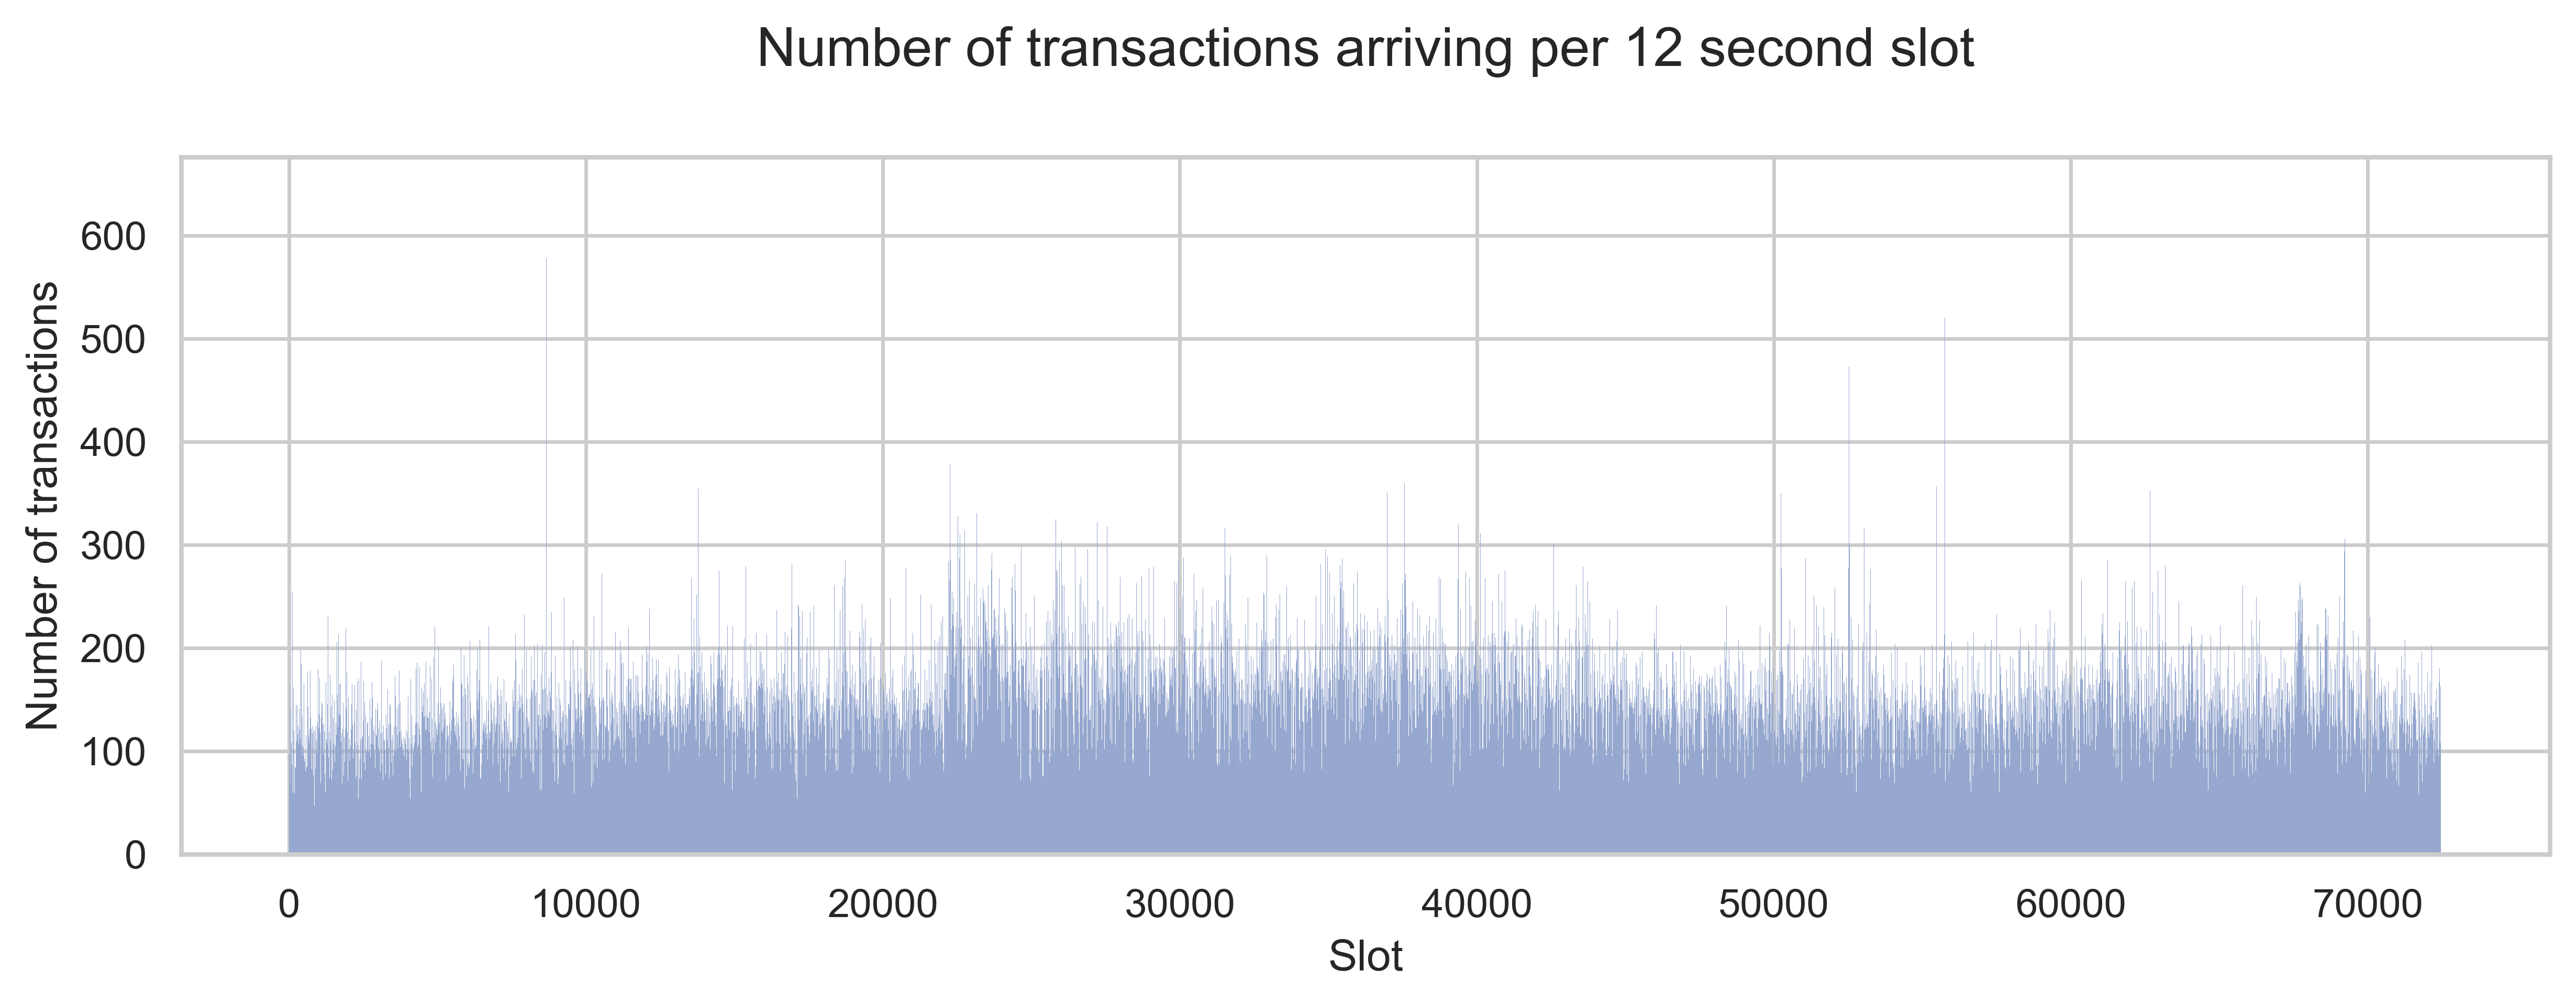

In [14]:
plt.figure(figsize=(10, 4))
ax = sns.histplot(
    tx_info_df,
    x="arrival_ts",
    binwidth=12,
    alpha=1.0,
    color="#8da0cb"
)
plt.title(
    "Number of transactions arriving per 12 second slot",
    pad=25,
)
plt.xlabel("Slot")
plt.ylabel("Number of transactions")
plt.tight_layout()
plt.show()

mean      155.244868
std        46.132488
median    150.000000
Name: count, dtype: float64


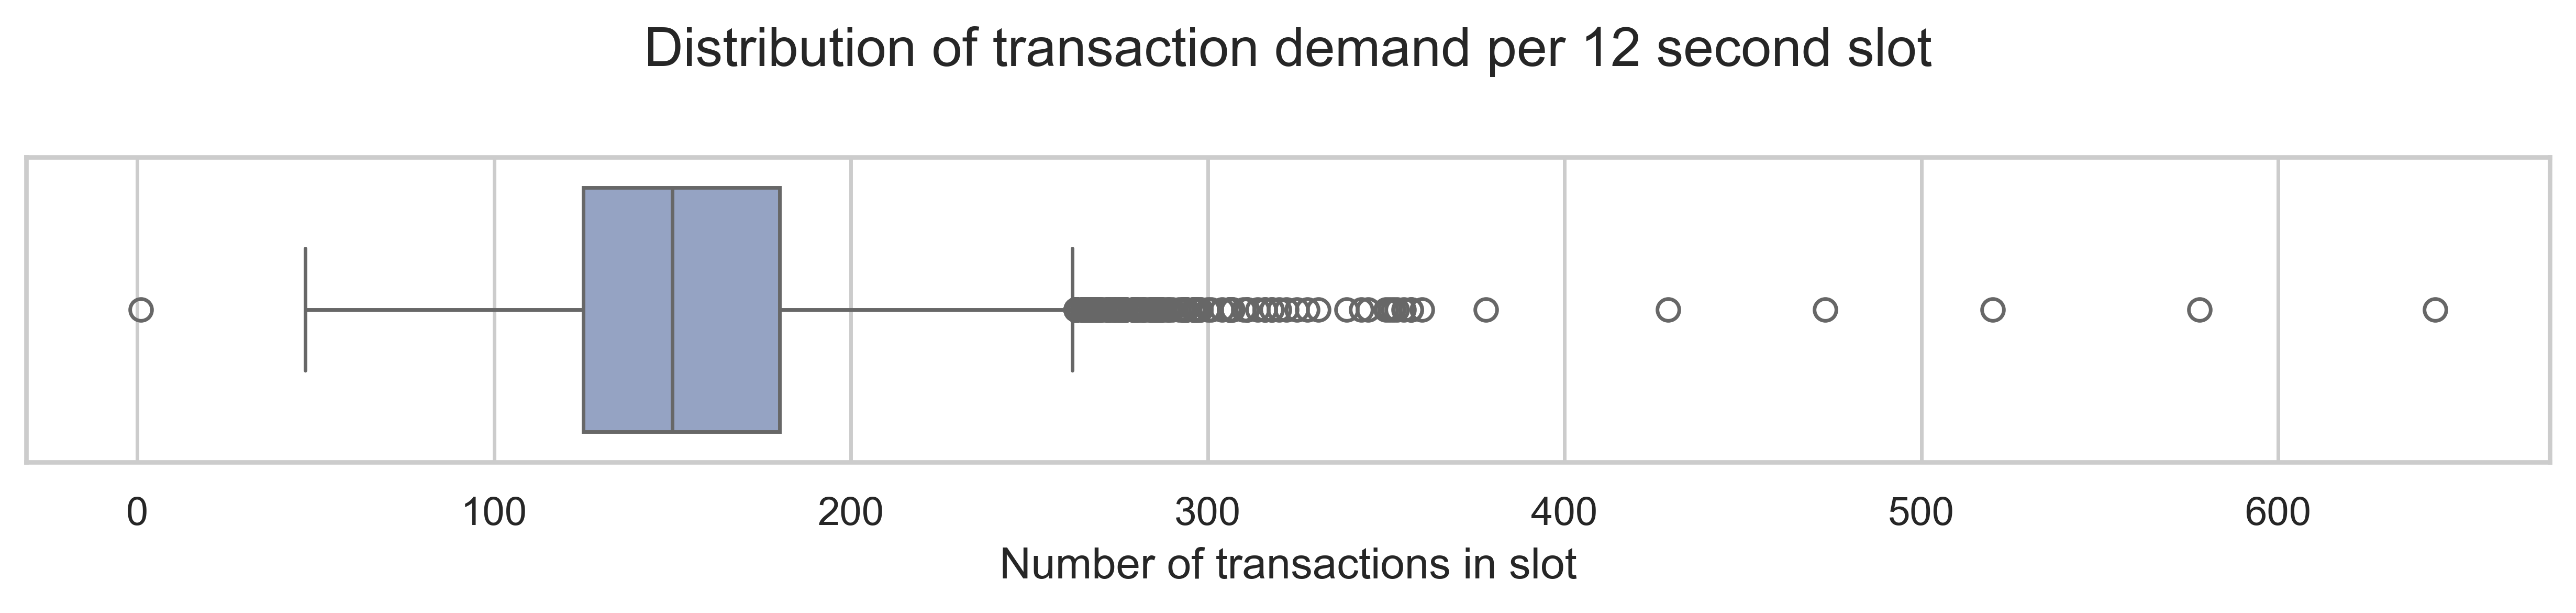

In [16]:
temp_df = tx_info_df.groupby("12s_slot").size().reset_index()
temp_df.columns = ["12s_slot", "count"]
print(temp_df["count"].agg(["mean", "std", "median"]))

plt.figure(figsize=(10, 2.5))
ax = sns.boxplot(
    temp_df.reset_index(),
    x="count",
    color="#8da0cb"
)
plt.title(
    "Distribution of transaction demand per 12 second slot",
    pad=25,
)
plt.xlabel("Number of transactions in slot")
plt.ylabel("")
plt.tight_layout()
plt.show()